<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Olympia_CAS_estimation_RepVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Olympia_Hertel_estimation_RepVGG-A2**

---



In [1]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
import time
import os
import copy
import statistics
import math
import shutil

import glob
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import seaborn as sns; sns.set()


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
黒の空白を挿入することにより500px*500pxの画像を生成
－－－－－－－－－－－－－－
データの構造
Olympia_dataset----dataset_500px_divided----train (72%)
                                            |
                                            |--val (18%)
                                            |
                                            |--test (10%)

'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 81kB 5.6MB/s 
Random Seed:  1234
Mounted at /content/drive


#**Set Parameters**

In [3]:
path = '/content/drive/MyDrive/Deep_learning/Olympia_dataset'
os.chdir(path)

# grav or cont, age, and sex
#NUM_CLASSES = 3

# contains train, val
#DATASET_PATH = r"./dataset_500px"
DATASET_PATH = r"./dataset_500px_divided"
#TRAIN_FOLDER_NAME = "train"
#VAL_FOLDER_NAME = "val"
#EFFICIENT_NET_NAME = "RepVGG-A2-train"
MODEL_PATH = "./RepVGG-A2-train.pth"
CSV_PATH = "./AI_modified.csv"
#OPTIMIZER_PATH = "./optimizer_multi.pth"
#SEX_DICT_PATH = "gender_json"
#AGE_DICT_PATH = "age_json"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
#CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 100 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 16

# transforms param　　左右分けているのでflipはしない
PX = 224
TRAIN_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
TRAIN_CROP_SCALE =(0.75,1.0)
VAL_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])]) 

In [16]:
df = pd.read_csv(CSV_PATH, encoding="shift-jis")
print(df)
print(df.iloc[1,:])


      写真No.  性  年令            自覚症状  腫脹  ...  CAS_結膜浮腫   合計  突出度　Ｒ  突出度　Ｌ      分類
0         1  男  57              なし   0  ...         0  0.0     11   11.0  コントロール
1         2  女  59              腫脹   1  ...         0  0.0     14   14.0       軽
2         3  女  47        腫脹、視力、開大   1  ...         0  1.0     12   13.0       中
3         4  女  49     眼突、腫脹、複視、開大   1  ...         0  1.0     20   19.0       中
4         5  男  52              眼突   0  ...         0  0.0     23   25.0       中
...     ... ..  ..             ...  ..  ...       ...  ...    ...    ...     ...
1011   1027  女  44           腫脹、複視   1  ...         0  0.0     14   14.0       軽
1012   1028  女  42  眼突、腫脹、複視、視力、開大   1  ...         0  2.0     22   19.0       中
1013   1029  女  69        腫脹、複視、視力   1  ...         0  1.0     19   20.0       重
1014   1030  女  44  眼突、腫脹、複視、視力、充血   1  ...         0  2.0     20   20.0       重
1015   1031  男  57              複視   0  ...         0  0.0     19   16.0       重

[1016 rows x 19 columns]
写真

#**Create Datasets**

In [33]:
class Create_Datasets(Dataset):
     
    def __init__(self, folder_path, csv_path, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.df = pd.read_csv(csv_path, encoding="shift-jis")
        df = self.df


        for image_name in os.listdir(folder_path):
            base_name, ext = os.path.splitext(image_name) #フォルダより画像番号を抜き出す
            swel_palp = df[df['写真No.']==int(base_name)].iloc[0,10] #CSV上で一致した番号の画像についてHertel値を抜き出す
            inj_conj = df[df['写真No.']==int(base_name)].iloc[0,11]
            inj_palp = df[df['写真No.']==int(base_name)].iloc[0,12]
            inj_caru = df[df['写真No.']==int(base_name)].iloc[0,13]
            swel_conj = df[df['写真No.']==int(base_name)].iloc[0,14]

            self.item_paths.append([os.path.join(folder_path, image_name), swel_palp, inj_conj, inj_palp, inj_caru, swel_conj])
            item_paths = self.item_paths
 
    def __len__(self):
        return len(self.item_paths)
     
    def __getitem__(self, index):
        image_path = self.item_paths[index][0]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image).float()
        swel_palp, inj_conj, inj_palp, inj_caru, swel_conj = self.item_paths[index][1], self.item_paths[index][2], self.item_paths[index][3], self.item_paths[index][4], self.item_paths[index][5]
        swel_palp =  torch.tensor(swel_palp)
        inj_conj =  torch.tensor(inj_conj)
        inj_palp = torch.tensor(inj_palp)
        inj_caru = torch.tensor(inj_caru)
        swel_conj = torch.tensor(swel_conj)
        target = torch.tensor([swel_palp, inj_conj, inj_palp, inj_caru, swel_conj]).float()

        return  tensor_image, target



train_dataset = Create_Datasets(DATASET_PATH+'/train', CSV_PATH, train_data_transforms)
val_dataset = Create_Datasets(DATASET_PATH+'/val', CSV_PATH, val_data_transforms)
test_dataset = Create_Datasets(DATASET_PATH+'/test', CSV_PATH, val_data_transforms) 
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = 1)

print('train_dataset_size: ' +str(len(train_dataset)))
print('val_dataset_size: ' +str(len(val_dataset)))
print('test_dataset_size: ' +str(len(test_dataset)))


train_dataset_size: 732
val_dataset_size: 183
test_dataset_size: 101


In [36]:
print(train_dataset[5])

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

#**Test with early-stopping**

In [37]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss




def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            target =target.squeeze(1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:  
            target = target.squeeze(1)         
            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

#**define RepVGG-A2**

In [40]:
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model





class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.fc = nn.Linear(in_features=1408, out_features=5) #out_featuresを5に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

#**ConvNetの調整**

In [41]:
model_ft = create_RepVGG_A2(deploy=False)
model_ft.load_state_dict(torch.load(MODEL_PATH)) 
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

In [42]:
model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)


Epoch: [  1/100] 
train_loss: 0.14168 
valid_loss: 0.10081 
Validation loss decreased (inf --> 0.100814).  Saving model ...

Epoch: [  2/100] 
train_loss: 0.08930 
valid_loss: 0.07378 
Validation loss decreased (0.100814 --> 0.073784).  Saving model ...

Epoch: [  3/100] 
train_loss: 0.06464 
valid_loss: 0.07512 
EarlyStopping counter: 1 out of 100

Epoch: [  4/100] 
train_loss: 0.05627 
valid_loss: 0.04923 
Validation loss decreased (0.073784 --> 0.049228).  Saving model ...

Epoch: [  5/100] 
train_loss: 0.04458 
valid_loss: 0.05037 
EarlyStopping counter: 1 out of 100

Epoch: [  6/100] 
train_loss: 0.03624 
valid_loss: 0.05185 
EarlyStopping counter: 2 out of 100

Epoch: [  7/100] 
train_loss: 0.03064 
valid_loss: 0.04232 
Validation loss decreased (0.049228 --> 0.042320).  Saving model ...

Epoch: [  8/100] 
train_loss: 0.02614 
valid_loss: 0.03261 
Validation loss decreased (0.042320 --> 0.032607).  Saving model ...

Epoch: [  9/100] 
train_loss: 0.02258 
valid_loss: 0.03858 
Earl

#**Draw Learning Curves**

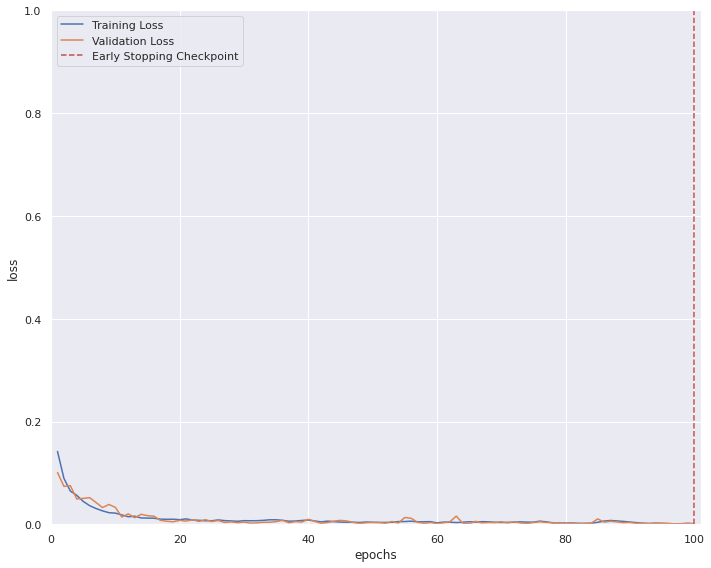

In [43]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#**Evaluation using testset**

In [50]:
def my_round(x, d=0):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p



model.eval() # prep model for evaluation

target_CAS = [[],[],[],[],[]]
output_CAS = [[],[],[],[],[]]



for image_tensor, target in test_loader:  
      target = target.squeeze(1)         
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(image_tensor)


      output_CAS[0].append(output[0,0].item())
      output_CAS[1].append(output[0,1].item()) 
      output_CAS[2].append(output[0,2].item()) 
      output_CAS[3].append(output[0,3].item()) 
      output_CAS[4].append(output[0,4].item()) 
 
      target_CAS[0].append(target[0,0].item())
      target_CAS[1].append(target[0,1].item())
      target_CAS[2].append(target[0,2].item())
      target_CAS[3].append(target[0,3].item())
      target_CAS[4].append(target[0,4].item())

print(output_CAS[0])
print(target_CAS[0])

"""
#平均からの差分を補正
corrected_outputR = (np.array(outputR)-np.array(statistics.mean(errorR))).tolist()
corrected_outputL = (np.array(outputL)-np.array(statistics.mean(errorL))).tolist()
corrected_errorR = (np.array(corrected_outputR)-np.array(targetR)).tolist()
corrected_errorL = (np.array(corrected_outputL)-np.array(targetL)).tolist()
corrected_AbsErrorR = [abs(i) for i in corrected_errorR]
corrected_AbsErrorL = [abs(i) for i in corrected_errorL]

round_outputR = [my_round(i) for i in outputR]
round_outputL = [my_round(i) for i in outputL]
round_corrected_AbsErrorR = [my_round(i) for i in corrected_AbsErrorR]
round_corrected_AbsErrorL = [my_round(i) for i in corrected_AbsErrorL]

print('Corrected_AveAbsError_R: '+str(statistics.mean(corrected_AbsErrorR)))
print('Corrected_AveAbsError_L: '+str(statistics.mean(corrected_AbsErrorL)))
print('Corrected_StdAbsError_R: '+str(statistics.stdev(corrected_AbsErrorR)))
print('Corrected_StdAbsError_L: '+str(statistics.stdev(corrected_AbsErrorL)))




#Draw Graphs
df_R = pd.DataFrame({'estimate':outputR, 'target':targetR})
#df_R = pd.DataFrame({'estimate':corrected_outputR, 'target':targetR, 'corrected_output':corrected_outputR, 'corrected_error':corrected_errorR, 'correceted_AbsError':round_corrected_AbsErrorR})
df_R['side']=np.tile('R', len(df_R))
df_L = pd.DataFrame({'estimate':outputL, 'target':targetL})
#df_L = pd.DataFrame({'estimate':corrected_outputL, 'target':targetL, 'corrected_output':corrected_outputR, 'corrected_error':corrected_errorL, 'correceted_AbsError':round_corrected_AbsErrorL})
df_L['side']=np.tile('L', len(df_L))

df_B= pd.concat([df_R, df_L])
#print(df_B)

sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='estimate', y='target', data=df_B, col='side')
plt.xlim(10,24)
plt.ylim(10,24)
"""



[-0.10526857525110245, 0.8407504558563232, 0.8340655565261841, 0.7870432138442993, 0.4643854796886444, 0.8112809062004089, -0.10306838154792786, 0.7209259867668152, 0.5531479716300964, 0.6018932461738586, -0.05633201450109482, 0.7096869945526123, 0.33147916197776794, 0.7856745719909668, -0.054076313972473145, 0.7723329663276672, -0.11613787710666656, 0.7260289788246155, -0.11727788299322128, 0.006477216258645058, -0.1044735535979271, -0.11971493065357208, 0.2718117833137512, 0.35912907123565674, -0.01936957612633705, -0.1231716126203537, 0.7909972071647644, 0.246090367436409, -0.10252194851636887, -0.029772961512207985, -0.14228253066539764, -0.09429464489221573, -0.12266884744167328, 0.3991946876049042, 0.8043221235275269, -0.09575752168893814, 0.7266820073127747, 0.8712989687919617, -0.10563503950834274, 0.6275141835212708, 0.4220179617404938, 0.7730273604393005, -0.05196373909711838, 0.3253636360168457, -0.09296713769435883, 0.778083324432373, 0.810211718082428, 0.7447024583816528, 

"\n#平均からの差分を補正\ncorrected_outputR = (np.array(outputR)-np.array(statistics.mean(errorR))).tolist()\ncorrected_outputL = (np.array(outputL)-np.array(statistics.mean(errorL))).tolist()\ncorrected_errorR = (np.array(corrected_outputR)-np.array(targetR)).tolist()\ncorrected_errorL = (np.array(corrected_outputL)-np.array(targetL)).tolist()\ncorrected_AbsErrorR = [abs(i) for i in corrected_errorR]\ncorrected_AbsErrorL = [abs(i) for i in corrected_errorL]\n\nround_outputR = [my_round(i) for i in outputR]\nround_outputL = [my_round(i) for i in outputL]\nround_corrected_AbsErrorR = [my_round(i) for i in corrected_AbsErrorR]\nround_corrected_AbsErrorL = [my_round(i) for i in corrected_AbsErrorL]\n\nprint('Corrected_AveAbsError_R: '+str(statistics.mean(corrected_AbsErrorR)))\nprint('Corrected_AveAbsError_L: '+str(statistics.mean(corrected_AbsErrorL)))\nprint('Corrected_StdAbsError_R: '+str(statistics.stdev(corrected_AbsErrorR)))\nprint('Corrected_StdAbsError_L: '+str(statistics.stdev(corrected_Ab

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


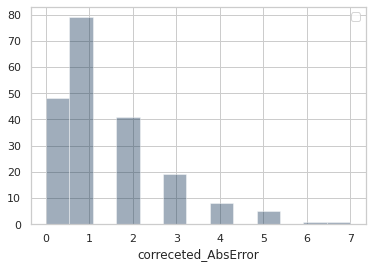

In [ ]:
sns.distplot(
    df_B['correceted_AbsError'], bins=13, color='#123456', 
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示

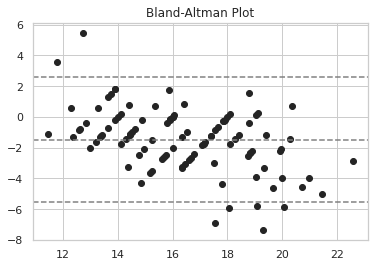

In [ ]:
#Bland-Altman-Plot

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputR, targetR)
plt.title('Bland-Altman Plot')
plt.show()


In [ ]:
#calculate correlation efficient

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


corr = df_B.corr()
print(corr)

                     estimate    target  corrected_output  corrected_error  \
estimate             1.000000  0.765154          0.973625        -0.019615   
target               0.765154  1.000000          0.738773        -0.658732   
corrected_output     0.973625  0.738773          1.000000        -0.009470   
corrected_error     -0.019615 -0.658732         -0.009470         1.000000   
correceted_AbsError  0.122757  0.178730          0.097076        -0.134094   

                     correceted_AbsError  
estimate                        0.122757  
target                          0.178730  
corrected_output                0.097076  
corrected_error                -0.134094  
correceted_AbsError             1.000000  
